# City of Philadelphia Licenses and Inspections Appeals

The dataset contains decisions of Philadelphia Licenses and Inspections Appeal Board. The dataset contains 28869 records and 37 columns.

Several columns such as Appeal Grounds, Related Permits and Proviso are in Natural Language format. 

Source: https://www.opendataphilly.org/dataset/license-and-inspections-appeals/resource/b721ad52-9e27-46d2-b494-6bf0ef1c7603?inner_span=True

### I would like to research the relationship of the board decision stored in the column 'decision' and other values in the dataset such as Appeal Grounds(NL), Related Permits(NL), Proviso(NL) and well as property address(geospatial).


### Loading necessary packages

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics #metrics module

hypertable=[]

### Load and review the data

In [2]:
#Database URL
url = 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+appeals&filename=appeals&format=csv&skipfields=cartodb_id'
#Initial Dataset load
df = pd.read_csv(url, low_memory=False)

In [3]:
#Sample data
df.head()

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
0,0101000020E61000008266D30997C952C01A1C17823CF9...,0101000020110F00003155059592E95FC13DDA01A36688...,1,593815.0,500-06 WALNUT ST,NaN,NaN,19106-3711,888501268.0,99332,...,2006-02-08 12:30:00,GRANTED/PROV,NaN,PROVISOS: Central air conditioning; Garbage di...,2006-02-23 00:00:00,HANSEN,2.697422e+06,234340.106753,39.947159,-75.149844
1,0101000020E6100000524C4BA2C4C652C0482BB29A2704...,0101000020110F000061186981C7E45FC1D9F3D20C8194...,2,2795.0,799 ADAMS AVE,NaN,NaN,19124-2327,882051160.0,540184,...,2009-10-28 14:00:00,GRANTED,NaN,NaN,2010-01-05 00:00:00,HANSEN,2.708849e+06,265766.335371,40.032459,-75.105752
2,0101000020E6100000C52903E74FCA52C09311DCA62FF9...,0101000020110F000038CC9C97CCEA5FC1A427E8645888...,3,547064.0,1201 SPRUCE ST,NaN,NaN,19107-5603,881517950.0,221809,...,2009-10-21 14:00:00,GRANTED/PROV,NaN,**Proviso - as per plans stamped by the Board ...,2009-10-21 00:00:00,HANSEN,2.694264e+06,234104.314141,39.946767,-75.161127
3,0101000020E61000001AD60399BDC852C057703BC5E5FC...,0101000020110F000025FCBC3C21E85FC182A76B2D758C...,4,754561.0,150 CECIL B MOORE AVE,NaN,NaN,19122-0000,183013005.0,540264,...,2009-10-21 14:00:00,GRANTED,NaN,NaN,2009-11-17 00:00:00,HANSEN,2.700833e+06,244864.919870,39.975762,-75.136572
4,0101000020E6100000A0845553CFCA52C0E5DA9A6577F9...,0101000020110F000040ED8208A5EB5FC1270846E0A788...,5,397995.0,1629 LOCUST ST,NaN,NaN,19103-6304,883046300.0,232156,...,2009-12-15 13:15:00,WITHDRAWN,NaN,NaN,2009-12-16 00:00:00,HANSEN,2.692061e+06,234837.744408,39.948956,-75.168904


In [4]:
#Number of rows and features
print("df.shape", df.shape)

df.shape (29564, 37)


In [5]:
#Column Names
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng'],
      dtype='object')

In [6]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29564 entries, 0 to 29563
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              28954 non-null  object 
 1   the_geom_webmercator  28954 non-null  object 
 2   objectid              29564 non-null  int64  
 3   addressobjectid       28993 non-null  float64
 4   address               28982 non-null  object 
 5   unit_type             98 non-null     object 
 6   unit_num              551 non-null    object 
 7   zip                   28982 non-null  object 
 8   opa_account_num       27734 non-null  float64
 9   parcel_id_num         28312 non-null  object 
 10  censustract           28954 non-null  float64
 11  opa_owner             28408 non-null  object 
 12  primaryappellant      29564 non-null  object 
 13  appellanttype         29022 non-null  object 
 14  internaljobid         27715 non-null  float64
 15  appealnumber       

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

***
### Clear out Null values

I am dropping records with Null value in Decision column. They represent less than 10% of the data. With the multitude of unique values in that column I can't decide what value I can replace it with.

In [7]:
df = df[~df['decision'].isna()]
df[df['systemofrecord'].isna()]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [8]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

In [9]:
df[df['lat'].isna()].shape[0]

17

I'm dropping these as well.

In [10]:
df = df[~df['lat'].isna()]

&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;&#9644;

### Clean Zip column

In [11]:
pd.concat([df['zip'].astype('str').str.slice(0,5), df['zip'].astype('str').str.slice(6,10)],axis = 1)

,zip,zip
0,19106,3711
1,19124,2327
2,19107,5603
3,19122,0000
4,19103,6304
...,...,...
29547,19133,2809
29548,19124,3900
29549,19120,1002
29550,19124,2452


In [12]:
#(df['zip'].astype('str').str.slice(0,5) + df['zip'].astype('str').str.slice(6,10)).astype('int')
#df['zip'].astype('str').str.slice(0,5).astype('int')

In [13]:
#Percent of unique values per values per column
df.nunique()/df.shape[0]

the_geom                0.802131
the_geom_webmercator    0.802131
objectid                1.000000
addressobjectid         0.814388
address                 0.805149
unit_type               0.000149
unit_num                0.004322
zip                     0.487240
opa_account_num         0.775046
parcel_id_num           0.772326
censustract             0.014232
opa_owner               0.706457
primaryappellant        0.458142
appellanttype           0.000261
internaljobid           0.983235
appealnumber            1.000000
acceleratedappeal       0.000075
createddate             0.998584
completeddate           0.449797
relatedpermit           0.981968
relatedcasefile         0.000037
appealstatus            0.000298
appealtype              0.000298
agendadescription       0.000037
applicationtype         0.000224
meetingnumber           0.016765
appealgrounds           0.922916
scheduleddate           0.174882
decision                0.001118
meetingresult           0.000261
proviso   

In [14]:
df.dtypes

the_geom                 object
the_geom_webmercator     object
objectid                  int64
addressobjectid         float64
address                  object
unit_type                object
unit_num                 object
zip                      object
opa_account_num         float64
parcel_id_num            object
censustract             float64
opa_owner                object
primaryappellant         object
appellanttype            object
internaljobid           float64
appealnumber             object
acceleratedappeal        object
createddate              object
completeddate            object
relatedpermit            object
relatedcasefile          object
appealstatus             object
appealtype               object
agendadescription        object
applicationtype          object
meetingnumber            object
appealgrounds            object
scheduleddate            object
decision                 object
meetingresult            object
proviso                  object
decision

In [15]:
df['createddate'] = pd.to_datetime(df['createddate'])

In [16]:
df['completeddate'] = pd.to_datetime(df['completeddate'])
df['scheduleddate'] = pd.to_datetime(df['scheduleddate'])
df['decisiondate'] = pd.to_datetime(df['decisiondate'])

In [17]:
#Top examples of "appealgrounds"
df['appealgrounds'].value_counts().head(10)

PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                       111
PERMIT FOR A TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                      65
WE ARE APPEALING THE ISSUANCE OF BUILDING PERMIT #765070 FOR HEALTH AND ENVIRONMENTAL CONCERNS.     63
PERMIT FOR THREE (3) FAMILY DWELLING (MULTI-FAMILY DWELLING) IN AN EXISTING STRUCTURE.              56
PERMIT FOR A TWO(2) FAMILY DWELLING.                                                                55
PERMIT FOR A THREE(3) FAMILY DWELLING.                                                              51
PERMIT FOR A TWO(2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                       37
PERMIT FOR A TWO (2) FAMILY DWELLING.                                                               36
PERMIT FOR A TWO FAMILY DWELLING.                                                                   35
PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE              

In [18]:
#Top examples of "relatedpermit"
df['relatedpermit'].value_counts().head(10)

Description of Project:  SM/LRG FOOD ESTAB\n  APPEAL TYPES==> \nAPPEAL TYPE: LI-REFGRNT  \n\n  BOARD DECISIONS==> \nDECISION: CONTINUED  DECDATE: 16-OCT-18  PROVISO:   \n\n  COURT APPEALS==> \n                                                                                                                                                                                                  29
Description of Project:  BUILDING PERMIT #765070\n  APPEAL TYPES==> \nAPPEAL TYPE: AGAINSTL&I  \n\n  BOARD DECISIONS==> \nDECISION: AFFIRMED  DECDATE: 28-JUL-17  PROVISO:   \n\n  COURT APPEALS==> \n                                                                                                                                                                                             28
Description of Project:  PWD\n  APPEAL TYPES==> \nAPPEAL TYPE: WATER  \n\n  BOARD DECISIONS==> \n\n  COURT APPEALS==> \n                                                                                                    

In [19]:
#Top value of "proviso"
df['proviso'].value_counts().head(10)

COMPLIED                                                          1751
FOR WANT OF APPEARANCE                                             737
*****CASE WITHDRAWN.*****                                          402
*****CASE DISMISSED.*****                                          163
*****CASE DISMISSED - PUT INTO ENFORCEMENT.*****                   109
60 DAY STAY OF ENFORCEMENT                                         101
90 DAY STAY OF ENFORCEMENT                                          85
30 DAY STAY OF ENFORCEMENT                                          58
WITHOUT PREJUDICE;  CITY HAS THE RIGHT TO RE-ISSUE VIOLATIONS.      54
120 DAY STAY OF ENFORCEMENT                                         53
Name: proviso, dtype: int64

In [20]:
#Breakdown by decision
df['decision'].value_counts()

GRANTED                  8436
GRANTED/PROV             6260
WITHDRAWN                2420
MOOT                     2283
AFFIRMED                 1956
DENIED                   1796
APPROVED                 1554
DISMISSED                 936
Complete                  401
SUSTAINED                 255
CONTINUED                 224
DENIED/PROV                69
ADMIN/REVIEW               63
DISMI/ENFORC               42
Dismissed / Withdrawn      39
REMAND                     38
HELD                       17
NEWHEARNOT                 12
HELD/INFO                   9
BOARDAKNOWL                 7
Continued                   6
LATE-APPRVD                 3
Cancelled                   3
REFUSED                     3
REVISED                     2
LATE-DENIED                 2
NEWHEARYES                  2
RESCHEDULE                  1
ISSUED                      1
Rescheduled                 1
Name: decision, dtype: int64

In [21]:
# Save the values
df['decisionsv']=df['decision']

In [22]:
df[(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == True)][['decision', 'proviso']]

,decision,proviso
3550,DENIED/PROV,NaN
25635,GRANTED/PROV,NaN


Even though there are only two records, it appears that /PROV in the 'decision' field doesn't mean that there is value in the field 'proviso'

In [23]:
df[~(df['decision'].str.contains('/PROV') == True) & (df['proviso'].isna() == False)][['decision', 'proviso']]

,decision,proviso
5,AFFIRMED,CITY WILL STAY ENFORCEMENT ACTION FOR 90 DAYS.
6,MOOT,COMPLIED
7,MOOT,COMPLIED
9,MOOT,COMPLIED
16,AFFIRMED,CITY WILL STAY ENFORCEMENT FOR 60 DAYS TO SECU...
...,...,...
29530,Complete,"Proviso: Per revised plans, 3 pages, approved ..."
29534,Continued,"With proviso: Revised plans, 1 page, approved ..."
29535,Complete,"With proviso: Revised plans, 1 page, approved ..."
29538,MOOT,COMPLIED


not having /PROV in 'decision' field doesn't mean no value in 'provision'

### Remove /PROV value from decision column and store it as a flag in a separate field

In [24]:
# Add new field prvFlag to store "/PROV" from decision
df['provFlag'] = (df['decision'].str.contains('/PROV') == True).astype('int')

In [25]:
df[df['decision'].str.contains('/PROV')]['decision'].str.len().unique()

array([12, 11], dtype=int64)

In [26]:
def stripProviso (decision):
    if '/PROV' in decision:
        strLength = len(decision)
        return decision[0: strLength-5]
    else:
        return decision

In [27]:
df['decision'] = df['decision'].apply(stripProviso)

In [28]:
df[['decision','decisionsv','provFlag']]

,decision,decisionsv,provFlag
0,GRANTED,GRANTED/PROV,1
1,GRANTED,GRANTED,0
2,GRANTED,GRANTED/PROV,1
3,GRANTED,GRANTED,0
4,WITHDRAWN,WITHDRAWN,0
...,...,...,...
29547,GRANTED,GRANTED,0
29548,DENIED,DENIED,0
29549,DENIED,DENIED,0
29550,Complete,Complete,0


### Change case for all decisions to lower case

In [29]:
df['decision'] = df['decision'].str.lower()

### Combine dismissed and withdrawn as dismissed

In [30]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismi/enforc', 'dismissed', 'dismissed / withdrawn']

In [31]:
def dismissed (decision):
    if 'dismi' in decision or decision == 'withdrawn':
        return 'dismissed'
    else:
        return decision

In [32]:
df['decision'] = df['decision'].apply(dismissed)

In [33]:
sorted(df[df['decision'].str.contains('dismi')]['decision'].unique())

['dismissed']

In [34]:
sorted(df['decision'].unique())

['admin/review',
 'affirmed',
 'approved',
 'boardaknowl',
 'cancelled',
 'complete',
 'continued',
 'denied',
 'dismissed',
 'granted',
 'held',
 'held/info',
 'issued',
 'late-apprvd',
 'late-denied',
 'moot',
 'newhearnot',
 'newhearyes',
 'refused',
 'remand',
 'reschedule',
 'rescheduled',
 'revised',
 'sustained']

In [35]:
df['decision'].value_counts()

granted         14696
dismissed        3437
moot             2283
affirmed         1956
denied           1865
approved         1554
complete          401
sustained         255
continued         230
admin/review       63
remand             38
held               17
newhearnot         12
held/info           9
boardaknowl         7
late-apprvd         3
refused             3
cancelled           3
newhearyes          2
late-denied         2
revised             2
reschedule          1
rescheduled         1
issued              1
Name: decision, dtype: int64

In [36]:
df[(df['decision'] == 'complete')]['meetingresult'].value_counts()

Granted      368
Denied        22
Withdrawn      4
Refused        3
Approved       2
Dismissed      2
Name: meetingresult, dtype: int64

In [37]:
df[(df['decision'] == 'continued')]['meetingresult'].value_counts()

Granted    2
Name: meetingresult, dtype: int64

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
### Translate appeal decision into new feature and reduce the number of outcomes

In [38]:
def translateComplete(meetingresult):
    switcher = {
        'Granted':'approved',
        'Denied':'denied',
        'Withdrawn':'other',
        'Dismissed':'denied',
        'Approved':'approved',
        'Refused':'denied'                
        }
    return switcher.get(meetingresult, 'other') 

#def CompleteDecision(decision, meetingresult):
def CompleteDecision(arg):
    if arg[0] == 'complete':
        return translateComplete(arg[1])
    else:
        return arg[0]

    
def funcNewDecision(decision): 
    switcher = {
        'admin/review': 'other',
        'affirmed':'denied',
        'approved':'approved',
        'boardaknowl':'other',
        'cancelled':'other',
        'complete':'complete',
        'continued':'other',
        'denied':'denied',
        'dismissed':'other',
        'granted':'approved',
        'held':'denied',
        'held/info':'denied',
        'issued':'other',
        'late-apprvd':'other',
        'late-denied':'other',
        'moot':'other',
        'newhearnot':'other',
        'newhearyes':'other',
        'refused':'denied',
        'remand':'other',
        'reschedule':'other',
        'rescheduled':'other',
        'revised':'other',
        'sustained':'denied'
        } 
    return switcher.get(decision, 'other') 

df['decision'].apply(funcNewDecision).value_counts()

df[df['decision'] == 'complete']['meetingresult'].apply(translateComplete).value_counts()

df[['decision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()

#df['newDecision'] = df[df['decision'] == 'complete'][['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision).value_counts()


granted         14696
dismissed        3437
moot             2283
affirmed         1956
approved         1924
denied           1892
sustained         255
continued         230
admin/review       63
remand             38
held               17
newhearnot         12
held/info           9
boardaknowl         7
other               4
refused             3
late-apprvd         3
cancelled           3
newhearyes          2
late-denied         2
revised             2
reschedule          1
rescheduled         1
issued              1
dtype: int64

In [39]:
df['newDecision'] = df['decision'].apply(funcNewDecision)
df['newDecision'] = df[['newDecision','meetingresult']].apply(tuple, axis=1).apply(CompleteDecision)
df['newDecision'].value_counts()

approved    16620
other        6089
denied       4132
Name: newDecision, dtype: int64

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

In [40]:
pd.set_option('display.max_colwidth', None)
df[df['decision'] == 'held/info'].head(5)

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
3994,0101000020E6100000CCF7447DB4CD52C0B3F0B9DC37F84340,0101000020110F0000B4D87CF98FF05FC10B2C36E745875241,3696,622915.0,5000-40 WOODLAND AVE,NaN,NaN,19143-5100,773182100.0,145910,...,FOR TAX CERT,2011-04-13,HANSEN,2.679485e+06,230919.547094,39.939205,-75.214141,HELD/INFO,0,denied
7075,0101000020E61000000BDC3CA74DCA52C06FEFAEB9B0034440,0101000020110F000051F299C5C8EA5FC1D48F1C31FD935241,6799,398758.0,34 E LOGAN ST,NaN,NaN,19144-3017,121004500.0,343791,...,VOTE IN 2 WEEKS; APPLICANT & COMMUNITY TO MEET RE: PARKING ISSUES; LETTER TO ZBA 2 WEEKS,2008-08-19,HANSEN,2.693426e+06,263987.075341,40.028831,-75.160990,HELD/INFO,0,denied
9764,0101000020E610000009FB5E34FECA52C0CB57E0F6A8F44340,0101000020110F0000F7F87AA9F4EB5FC1A043E81B55835241,9870,51909.0,3101 S BROAD ST,NaN,NaN,19148-5239,395370400.0,183090,...,VOTE 3/18/08; HOLD FOR 5-PAGE SUMMARY FROM EACH SIDE.,2008-03-20,HANSEN,2.691658e+06,221141.422866,39.911406,-75.171765,HELD/INFO,0,denied
19464,0101000020E6100000DDCDED235ECB52C058A5DB6590F74340,0101000020110F000000615C9E97EC5FC1D3290B698C865241,19925,671302.0,1400 S 20TH ST,NaN,NaN,19146-4507,871549280.0,25999,...,HELD 60 DAYS PENDING REVISED REFUSAL FROM L&I & RCO MEETING/COUNCIL PERSON,2020-01-22,HANSEN,2.689776e+06,229354.773235,39.934094,-75.177621,HELD/INFO,0,denied
20566,0101000020E6100000ACCC8E97F4C952C02A4FBFD171004440,0101000020110F000026FB0C7E31EA5FC143D33AC363905241,20285,660781.0,3259 N 16TH ST,NaN,NaN,19140-4910,112194800.0,250252,...,letter from RCO and C/W,2019-02-06,HANSEN,2.695219e+06,254798.523686,40.003473,-75.155554,HELD/INFO,0,denied


In [41]:
df[df['proviso'].isnull() == True]
df[(df['decision'].str.contains("PROV") == True) & (df['decision'] != 'approved')  & (df['proviso'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [42]:
df[df['meetingresult'].isnull() == False]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
34,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263,Complete,0,approved
231,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,238,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394,Complete,0,approved
263,0101000020E6100000B692B43A1FC952C0593D2949E3FC4340,0101000020110F000010520913C7E85FC19B51786C728C5241,271,15456898.0,1618 GERMANTOWN AVE,NaN,NaN,19122-3017,183160510.0,436927,...,"With proviso: (1) revised plans, 1 pg., approved today.",2020-10-14 11:31:12,ECLIPSE,2.699165e+06,244787.950990,39.975686,-75.142531,Complete,0,approved
303,0101000020E6100000525BD8498ECA52C08A6C64CDACF94340,0101000020110F0000A7D9AD8F36EB5FC1AA35D00AE3885241,309,15795392.0,1416 CHESTNUT ST,NaN,NaN,19102-2505,883421500.0,183272,...,NaN,2020-09-23 10:17:09,ECLIPSE,2.693156e+06,235463.747317,39.950586,-75.164935,Complete,0,approved
342,0101000020E610000096D371D26BCB52C0324FE2EF85FD4340,0101000020110F0000987ABCDBAEEC5FC1C8D7DAB1268D5241,352,15878465.0,1620 N BAILEY ST,NaN,NaN,19121-2802,324117000.0,281443,...,NaN,2020-11-12 18:24:49,ECLIPSE,2.689048e+06,246300.194969,39.980650,-75.178456,Complete,0,approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29534,0101000020E61000007B0CC9575BCB52C0A5E656A381054440,0101000020110F0000D03EEBDD92EC5FC18EB86DE700965241,29128,15736907.0,93 HERMAN ST,NaN,NaN,19144-2016,592087900.0,422528,...,"With proviso: Revised plans, 1 page, approved today.",2020-09-21 17:38:30,ECLIPSE,2.688668e+06,269018.643897,40.043019,-75.177450,Continued,0,other
29535,0101000020E61000003938755740CC52C09022F4BDB7FB4340,0101000020110F0000AA3E20D817EE5FC194760D77268B5241,29129,129640659.0,3300 MANTUA AVE,NaN,NaN,19104-1608,242000210.0,1472008,...,"With proviso: Revised plans, 1 page, approved today.",2020-11-12 17:34:00,ECLIPSE,2.685563e+06,241058.556192,39.966545,-75.191427,Complete,0,approved
29536,0101000020E61000003B9F1CE545CC52C01F0E688CBAFB4340,0101000020110F0000A1BCF24621EE5FC1B40E3393298B5241,29130,168205361.0,3316 MANTUA AVE,NaN,NaN,19104-1608,243000610.0,1472291,...,NaN,2020-11-12 16:50:27,ECLIPSE,2.685467e+06,241086.990411,39.966631,-75.191766,Complete,0,approved
29550,0101000020E61000002C7AFAF690C652C015E0ED183F044440,0101000020110F00005BD77BBD6FE45FC1B68AE81B9B945241,29026,128693855.0,5300 WHITAKER AVE,NaN,NaN,19124-2452,882885808.0,98627,...,NaN,2020-10-07 13:55:47,ECLIPSE,2.709724e+06,266053.845777,40.033176,-75.102598,Complete,0,approved


In [43]:
(df['decision'] + " - " + df['meetingresult']).value_counts()

complete - Granted       368
dismissed - Withdrawn     37
complete - Denied         22
complete - Withdrawn       4
complete - Refused         3
cancelled - Withdrawn      2
complete - Dismissed       2
continued - Granted        2
complete - Approved        2
cancelled - Revised        1
rescheduled - Refused      1
dtype: int64

In [44]:
df[(df['decision']=='complete') & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [45]:
df[(df['decision']=='granted') & (df['meetingresult'].isnull() == False)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [46]:
df['systemofrecord'].value_counts()

HANSEN     26391
ECLIPSE      450
Name: systemofrecord, dtype: int64

In [47]:
# I want to see if the two system of records overlap
for sysname in df['systemofrecord'].unique():
    print(sysname)
    print(df[df['systemofrecord']==sysname]['createddate'].agg(['min','max']))

HANSEN
min   2007-01-22 09:41:00
max   2020-03-09 16:19:20
Name: createddate, dtype: datetime64[ns]
ECLIPSE
min   2018-02-20 10:48:46
max   2020-09-21 10:00:39
Name: createddate, dtype: datetime64[ns]


In [48]:
df[(df['systemofrecord']=='HANSEN') & (df['meetingresult'].isnull() == False)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision


In [49]:
df[(df['systemofrecord']=='ECLIPSE') & (df['decision'].isnull() == False) & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng,decisionsv,provFlag,newDecision
23379,0101000020E6100000626DE93412CC52C084945E7172FD4340,0101000020110F0000D998B97AC9ED5FC1915F8C16118D5241,23065,15830744.0,1501 N 33RD ST,NaN,NaN,19121-3513,292315605.0,90942,...,NaN,2020-09-30 17:01:36,ECLIPSE,2.686209e+06,246000.873419,39.980055,-75.188611,Continued,0,other
23735,0101000020E6100000ADFD74DAEBBD52C002EB9FFD050B4440,0101000020110F00000F68388CC0D55FC1D33B053D209C5241,24177,159412601.0,4501 WOODHAVEN RD,#,1B,19154-3145,882691010.0,495596,...,NaN,2020-07-16 12:10:37,ECLIPSE,2.746923e+06,286493.835007,40.086120,-74.967520,Dismissed / Withdrawn,0,other
23837,0101000020E610000078EC83545CCB52C0FCF5F84046F84340,0101000020110F000086CB348B94EC5FC1F9FF40D855875241,24197,15696117.0,2031 WASHINGTON AVE,NaN,NaN,19146-2632,884006315.0,137226,...,NaN,2020-06-30 18:49:58,ECLIPSE,2.689748e+06,231376.510551,39.939644,-75.177510,Continued,0,other
24502,0101000020E6100000D22989D1C9CB52C0C9AD1D1C9DF74340,0101000020110F0000646951854EED5FC10D5F847D9A865241,24886,15604187.0,2356 GERRITT ST,NaN,NaN,19146-4107,364015800.0,90476,...,NaN,2020-11-18 17:12:17,ECLIPSE,2.687929e+06,229442.423224,39.934482,-75.184193,Continued,0,other
25102,0101000020E6100000DCB07AA8FDC952C08DCE794002FA4340,0101000020110F0000338D5EE440EA5FC18F8546B641895241,24629,128762194.0,43 N 10TH ST,NaN,NaN,19107-1311,883704410.0,336648,...,NaN,2020-05-14 09:46:22,ECLIPSE,2.695602e+06,236485.840297,39.953194,-75.156107,Dismissed / Withdrawn,0,other
25176,0101000020E610000000A54FC031C752C013E548B1FFFE4340,0101000020110F0000323A26DA80E55FC1EF89256CC98E5241,24551,134576649.0,3114 FRANKFORD AVE,NaN,NaN,19134-3821,252487805.0,218135,...,NaN,2020-11-19 20:06:21,ECLIPSE,2.707423e+06,251043.621507,39.992178,-75.112412,Continued,0,other


It appears that there are two system of records. 
- HANSEN records have value of "decision" in upper case and have null valuye for "meetingresult"
- ECLIPSE records have value of "decision" in lower case and except for 8 records have additional value in the "meetingresult" column.

In [50]:
df[(df['decision']=='affirmed') & (~df['proviso'].isnull())].head(2).T

,5,16
the_geom,0101000020E6100000DA7B120E01CA52C0F0294B399D054440,0101000020E6100000228F28042FCD52C07A65FA16C7034440
the_geom_webmercator,0101000020110F00009CE075A946EA5FC159D7E1811F965241,0101000020110F00007076D041ADEF5FC18D805CFF15945241
objectid,6,17
addressobjectid,448281,606968
address,2109-11 W NEDRO AVE,600 WENDOVER ST
unit_type,NaN,NaN
unit_num,NaN,NaN
zip,19138-2941,19128-1719
opa_account_num,8.71091e+08,2.13118e+08
parcel_id_num,451808,106012


In [51]:
df['appealstatus'].value_counts()

CLOSED                   14331
OPEN                     12060
In Process                 329
Completed                   80
Waiting Period              30
Dismissed / Withdrawn        9
Closed                       1
Prepare Meeting              1
Name: appealstatus, dtype: int64

In [52]:
df[df['appealstatus'].isin(['CLOSED','Completed','Dismissed / Withdrawn','Closed'])]['decision'].value_counts()

granted         9542
dismissed       2293
denied          1360
approved         899
affirmed         101
moot              84
complete          80
sustained         16
admin/review      11
newhearnot         8
continued          8
boardaknowl        5
held/info          5
refused            3
revised            2
held               1
issued             1
late-denied        1
remand             1
Name: decision, dtype: int64

In [53]:
df['censustract'].describe().T

count    26841.000000
mean       249.306315
std        924.883473
min          1.000000
25%         42.020000
50%        149.000000
75%        259.000000
max       9891.000000
Name: censustract, dtype: float64

In [54]:
df[df['decision'].isna() ][['appealstatus','appellanttype','createddate','agendadescription','decision','decisiondate']]

,appealstatus,appellanttype,createddate,agendadescription,decision,decisiondate


In [55]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0

In [56]:
df[['lat','lng']].agg([min,max, 'mean']).T

,min,max,mean
lat,39.880338,40.137052,39.984471
lng,-75.274212,-74.961283,-75.153713


In [57]:
#Save Philadelphia Center City Latitude and Longitude.
ccLat = 39.952583
ccLng = -75.165222

In [58]:
#create "distance" from center city 
df['fromCC'] = ((df['lat']-ccLat)**2 + (df['lng']-ccLng)**2)**0.5
df['latfromCC']=df['lat']-ccLat
df['lngfromCC']=df['lng']-ccLng

In [59]:
df['fromCC'].agg(['max','min'])

max    0.252279
min    0.000070
Name: fromCC, dtype: float64

In [60]:
df[['lat','geocode_y']].corr()

,lat,geocode_y
lat,1.000000,0.999753
geocode_y,0.999753,1.000000


In [61]:
df[['lng','geocode_x']].corr()

,lng,geocode_x
lng,1.000000,0.999597
geocode_x,0.999597,1.000000


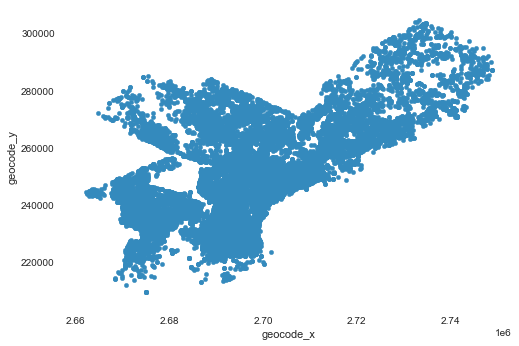

In [62]:
df.plot.scatter('geocode_x','geocode_y')

In [63]:
try:
    os.mkdir('images')
except:
    print('directory already exists')

directory already exists


In [64]:
df['newDecision'].unique()

array(['approved', 'other', 'denied'], dtype=object)

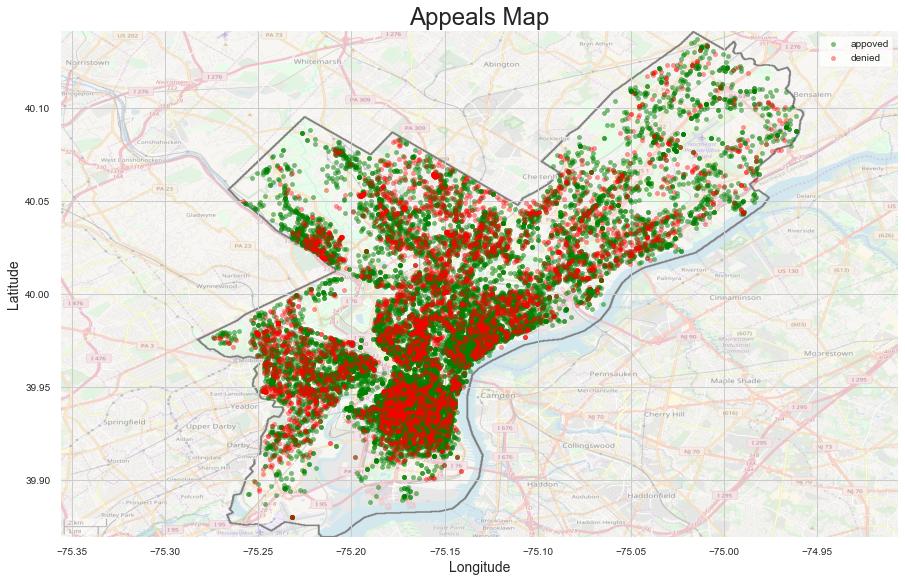

In [98]:
import numpy as np
import matplotlib.image as mpimg
philadelphia_img=mpimg.imread('images/Street_map_of_Philadelphia_and_surrounding_area.png')

plt.axes
plt.figure(figsize=(15,15))
plt.title('Appeals Map', size=24)
plt.rc('font', size=24)

plt.imshow(philadelphia_img, extent=[-75.356, -74.9066, 39.8694, 40.1414], alpha=0.5)

dfscat = df[df['newDecision'] == 'approved']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'appoved', s=20, alpha=0.5, c='green')

dfscat = df[df['newDecision'] == 'denied']
plt.scatter(dfscat['lng'], dfscat['lat'], marker = 'o', label = 'denied', s=20, alpha=0.4, c='red')


plt.grid('on')
plt.legend()
plt.rc('font', size=18)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.savefig('images/appeal_map.png',bbox_inches='tight')
plt.show()

 

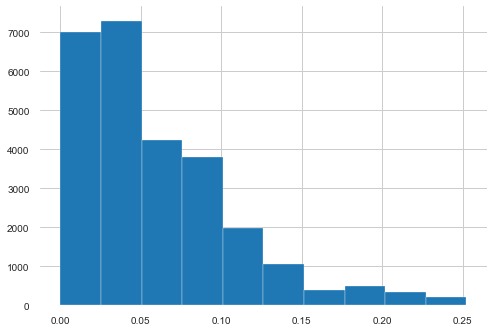

In [66]:
#Distance from CC
df['fromCC'].hist()

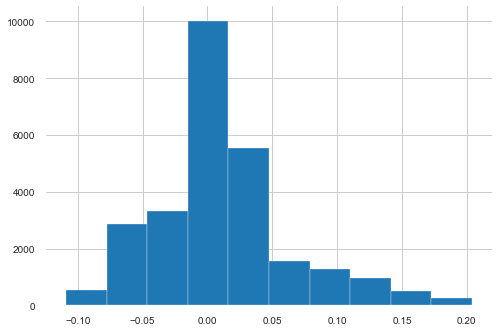

In [67]:
#Longtitude from CC
df['lngfromCC'].hist()

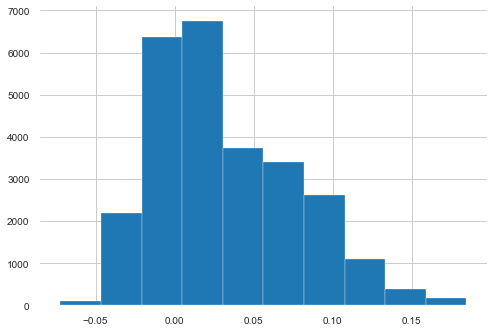

In [68]:
#Latitude from CC
df['latfromCC'].hist()

### myMetrics Function for model testing

In [130]:
# Create metrics function to check metrics for different models

def myMetrics(model=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None):
    
    hypertablerow={}
    hypertablerow['model']=model.__class__.__name__
    #print("Model:", model.__class__.__name__)
    hypertablerow['features']=features

    X_train_temp = X_train[features]
    X_test_temp = X_test[features]  
    print("X_train_temp.columns:", X_train_temp.columns)
    model.fit(X_train_temp,y_true_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)
    print("y_pred_test.shape:", y_pred_test.shape)
    print("y_pred_train.shape:", y_pred_train.shape)


    # Accuracy
    hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
    print('accuracy_test', hypertablerow['accuracy_test'])
    hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
    print('accuracy_train', hypertablerow['accuracy_train'])
    # Precision
    hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('precision_test', hypertablerow['precision_test'])
    hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('precision_train', hypertablerow['precision_train'])
    # Recall
    hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test, average = 'weighted')
    #print('recall_test', hypertablerow['recall_test'])
    hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train, average = 'weighted')
    #print('recall_train', hypertablerow['recall_train'])

    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
    return hypertablerow

In [99]:
# Create "dummy" variables for systemofrecord columns
df = pd.concat([df, pd.get_dummies(df['systemofrecord'])], axis=1)
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'decisionsv', 'provFlag',
       'newDecision', 'fromCC', 'latfromCC', 'lngfromCC', 'ECLIPSE', 'HANSEN'],
      dtype='object')

In [100]:
# Declare an explanatory variable, and assign some data to it 
#X = df[['ECLIPSE', 'HANSEN']]
X = df.drop(['newDecision'], axis=1)

# Declare a response variable, the decision column of the df 
y = df['newDecision'] 

In [101]:
X.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'decisionsv', 'provFlag',
       'fromCC', 'latfromCC', 'lngfromCC', 'ECLIPSE', 'HANSEN'],
      dtype='object')

In [102]:
# import the preprocessing package
from sklearn import preprocessing

# Call the train_test_split() function
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [120]:
print('X_train.shape',X_train.shape)
print('X_test.shape',X_test.shape)
print('y_train.size', y_train.size)
print('y_test.size', y_test.size)
print('y_train.describe() \n',y_train.describe())
print('\n y_train.describe()')
y_test.describe()

X_train.shape (20130, 44)
X_test.shape (6711, 44)
y_train.size 20130
y_test.size 6711
y_train.describe() 
 count        20130
unique           3
top       approved
freq         12431
Name: newDecision, dtype: object

 y_train.describe()


count         6711
unique           3
top       approved
freq          4189
Name: newDecision, dtype: object

In [131]:
from sklearn import svm
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE', 'HANSEN']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'HANSEN'], dtype='object')
y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.6241990761436448
accuracy_train 0.6175360158966716


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
from sklearn import svm
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE']
#hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)
y_true_train = y_train
y_true_test = y_test
#y_true_train = y_train.to_numpy
#y_true_test = y_test.to_numpy


hypertablerow={}
hypertablerow['model']=model.__class__.__name__
print("Model:", model.__class__.__name__)
hypertablerow['features']=features

X_train_temp = X_train[features]
X_test_temp = X_test[features]  
print("X_train_temp.columns:", X_train_temp.columns)
model.fit(X_train_temp,y_true_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
print("y_pred_test.describe:", y_pred_test)
print("y_pred_train.describe:", y_pred_train)

print('type(y_pred_test)', type(y_pred_test))
print('type(y_true_test)', type(y_true_test))

# Accuracy
hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test.to_numpy(), y_pred=y_pred_test)
print('accuracy_test', hypertablerow['accuracy_test'])
hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train.to_numpy(), y_pred=y_pred_train)
print('accuracy_train', hypertablerow['accuracy_train'])
# Precision
hypertablerow['precision_test'] = metrics.precision_score(y_true=y_true_test, y_pred=y_pred_test, average = 'weighted')
print('precision_test', hypertablerow['precision_test'])
hypertablerow['precision_train'] = metrics.precision_score(y_true=y_true_train, y_pred=y_pred_train, average = 'weighted')
print('precision_train', hypertablerow['precision_train'])
# Recall
hypertablerow['recall_test'] = metrics.recall_score(y_true=y_true_test, y_pred=y_pred_test, average = 'weighted')
print('recall_test', hypertablerow['recall_test'])
hypertablerow['recall_train'] = metrics.recall_score(y_true=y_true_train, y_pred=y_pred_train, average = 'weighted')
print('recall_train', hypertablerow['recall_train'])

hypertable.append(hypertablerow)
pd.Series(hypertablerow)

Model: LinearSVC
X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.describe: ['approved' 'approved' 'approved' ... 'approved' 'approved' 'approved']
y_pred_train.describe: ['approved' 'approved' 'approved' ... 'approved' 'approved' 'approved']
type(y_pred_test) <class 'numpy.ndarray'>
type(y_true_test) <class 'pandas.core.series.Series'>
accuracy_test 0.6241990761436448
accuracy_train 0.6175360158966716
precision_test 0.3896244866585796


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_train 0.38135073092953425
recall_test 0.6241990761436448
recall_train 0.6175360158966716


model              LinearSVC
features           [ECLIPSE]
accuracy_test       0.624199
accuracy_train      0.617536
precision_test      0.389624
precision_train     0.381351
recall_test         0.624199
recall_train        0.617536
dtype: object

In [133]:
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE'], dtype='object')
y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.6241990761436448
accuracy_train 0.6175360158966716


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE', 'fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'latfromCC', 'lngfromCC'], dtype='object')
y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.6241990761436448
accuracy_train 0.617585692995529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'HANSEN', 'fromCC', 'latfromCC', 'lngfromCC'], dtype='object')
y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.6241990761436448
accuracy_train 0.617585692995529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'latfromCC', 'lngfromCC'], dtype='object')
y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.6241990761436448
accuracy_train 0.617585692995529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [137]:
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE','fromCC', 'latfromCC', 'lngfromCC', 'censustract']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'fromCC', 'latfromCC', 'lngfromCC', 'censustract'], dtype='object')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.34719117866189836
accuracy_train 0.34063586686537506


In [138]:
model = svm.LinearSVC() # Linear Kernel
features=['ECLIPSE','fromCC', 'latfromCC', 'lngfromCC', 'censustract']
#features=['ECLIPSE','fromCC', 'latfromCC', 'lngfromCC']

#hypertablerow={}
#hypertablerow['model']=model.__class__.__name__
#hypertablerow['features']=features

X_train_temp = X_train[features]
X_test_temp = X_test[features]  
print(X_train_temp.columns)
model.fit(X_train_temp,y_train)
    
y_pred_test = model.predict(X_test_temp)
y_pred_train = model.predict(X_train_temp)
y_true_test = y_test
y_true_train = y_train

# Accuracy
hypertablerow['accuracy_test'] = metrics.accuracy_score(y_true=y_true_test, y_pred=y_pred_test)
print('accuracy_test', hypertablerow['accuracy_test'])
hypertablerow['accuracy_train'] = metrics.accuracy_score(y_true=y_true_train, y_pred=y_pred_train)
print('accuracy_train', hypertablerow['accuracy_train'])
"""
# Precision
hypertablerow['precision_test'] = metrics.precision_score(y_true_test, y_pred_test, average = 'weighted')
#print('precision_test', hypertablerow['precision_test'])
hypertablerow['precision_train'] = metrics.precision_score(y_true_train, y_pred_train, average = 'weighted')
#print('precision_train', hypertablerow['precision_train'])
# Recall
hypertablerow['recall_test'] = metrics.recall_score(y_true_test, y_pred_test, average = 'weighted')
#print('recall_test', hypertablerow['recall_test'])
hypertablerow['recall_train'] = metrics.recall_score(y_true_train, y_pred_train, average = 'weighted')
#print('recall_train', hypertablerow['recall_train'])

hypertable.append(hypertablerow)
    
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)
"""

Index(['ECLIPSE', 'fromCC', 'latfromCC', 'lngfromCC', 'censustract'], dtype='object')
accuracy_test 0.36283713306511695
accuracy_train 0.35384997516145056


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


"\n# Precision\nhypertablerow['precision_test'] = metrics.precision_score(y_true_test, y_pred_test, average = 'weighted')\n#print('precision_test', hypertablerow['precision_test'])\nhypertablerow['precision_train'] = metrics.precision_score(y_true_train, y_pred_train, average = 'weighted')\n#print('precision_train', hypertablerow['precision_train'])\n# Recall\nhypertablerow['recall_test'] = metrics.recall_score(y_true_test, y_pred_test, average = 'weighted')\n#print('recall_test', hypertablerow['recall_test'])\nhypertablerow['recall_train'] = metrics.recall_score(y_true_train, y_pred_train, average = 'weighted')\n#print('recall_train', hypertablerow['recall_train'])\n\nhypertable.append(hypertablerow)\n    \nhypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)\n"

In [139]:
model = svm.SVC(kernel='linear') # Linear Kernel
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

X_train_temp.columns: Index(['ECLIPSE', 'HANSEN', 'fromCC', 'latfromCC', 'lngfromCC'], dtype='object')
y_pred_test.shape: (6711,)
y_pred_train.shape: (20130,)
accuracy_test 0.6241990761436448
accuracy_train 0.6175360158966716


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = svm.SVC(kernel='poly') # Linear Kernel
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

In [ ]:
model = svm.SVC(kernel='sigmoid') # Linear Kernel
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

In [ ]:
model = svm.SVC(kernel='rbf') # Linear Kernel
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
features=['ECLIPSE', 'HANSEN','fromCC', 'latfromCC', 'lngfromCC']
hypertablerow = myMetrics(model=model,features=features,X_train=X_train,y_true_train=y_train,X_test=X_test,y_true_test=y_test)

...

In [ ]:
pd.DataFrame(hypertable).to_csv('hypertable.csv')
dfhypertable=pd.DataFrame(hypertable).sort_values('accuracy_test')
pd.set_option('display.max_colwidth', -1)
dfhypertable.sort_values('accuracy_test',  ascending=False)